<a href="https://colab.research.google.com/github/Song-z-h/data-intensive-proj/blob/master/recomendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Progetto: Book Recommendation

**Programmazione di Applicazioni Data Intensive**  
Laurea in Ingegneria e Scienze Informatiche  
DISI - Università di Bologna, Cesena

zhaohui.song@studio.unibo.it  giuseppe.pintus2@studio.unibo.it


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


dataset
https://www.kaggle.com/code/sercanyesiloz/book-recommendation-system/input?select=Books+Data+with+Category+Language+and+Summary

# Project objective

## Import data

In [2]:
import os
import numpy as np
import pandas as pd

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline
import gc

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import euclidean_distances
from scipy.spatial.distance import cdist

import warnings
warnings.filterwarnings("ignore")

In [3]:
import zipfile

#substitute this path with the path in your drive, or just load the zip file
with zipfile.ZipFile('drive/MyDrive/dataintensive/archive.zip', 'r') as zip_ref:
    zip_ref.extractall('data')


In [4]:
import pandas as pd

df = pd.read_csv('data/Preprocessed_data.csv')

#dfuser = pd.read_csv('data/reviews/BX-Users.csv', encoding="latin-1", sep=";" , on_bad_lines='skip')

#dfrate = pd.read_csv('data/reviews/BX-Book-Ratings.csv', encoding="latin-1", sep=";" , on_bad_lines='skip')

#dfbook = pd.read_csv('data/reviews/BX-Books.csv', encoding="latin-1", sep=";" , on_bad_lines='skip')



# Data Description

In [5]:
ratings_df =df[["user_id","isbn","rating"]]
ratings_df.head(5)

,user_id,isbn,rating
0,2,0195153448,0
1,8,0002005018,5
2,11400,0002005018,0
3,11676,0002005018,8
4,41385,0002005018,0


In [6]:
set_size=200000
ratings = ratings_df[:set_size]
#ratings = ratings_df

In [7]:
ratings.set_index(["user_id", "isbn"], inplace=True)


In [8]:
ratings.head(3)

,,rating
user_id,isbn,
2,0195153448,0
8,0002005018,5
11400,0002005018,0


In [9]:
#ratings = ratings["rating"].unstack("isbn")
ratings = ratings["rating"].unstack("isbn").astype(pd.SparseDtype("float", np.nan))

In [10]:
# Count non-null elements in each row and store in a new column 'count_non_null'
ratings['count_non_null'] = ratings.count(axis=1)


In [11]:
ratings.iloc[:5,:5]

isbn,0002005018,0002740230,0006276199,0006329527,000636988X
user_id,,,,,
2,NaN,NaN,NaN,NaN,NaN
8,5.0,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN
12,NaN,NaN,NaN,NaN,NaN


In [12]:

# Sort by 'count_non_null' in descending order
sorted_ratings = ratings.sort_values(by='count_non_null', ascending=False)

# Take the top 200 rows
top_200_ratings = sorted_ratings.head(300)

# Drop the 'count_non_null' column
top_200_ratings = top_200_ratings.drop(columns=['count_non_null'])

# Create a new matrix (numpy array) from the top 200 rows
ratings = top_200_ratings

In [13]:
ratings.iloc[:5, :5]

isbn,0002005018,0002740230,0006276199,0006329527,000636988X
user_id,,,,,
11676,8.0,NaN,NaN,NaN,NaN
3363,NaN,NaN,NaN,NaN,NaN
35859,NaN,NaN,NaN,NaN,NaN
153662,NaN,NaN,NaN,NaN,NaN
76352,NaN,NaN,NaN,NaN,NaN


In [14]:
R = ratings.fillna(0).values

In [15]:
R[:5, :5]

array([[8., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [16]:
P = ratings.notna().values

In [17]:
P[:5, :5]

array([[ True, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False]])

# Data exploration

Extracting useful information from the matrix `P` and `R`.

In [18]:
print("number of ratings:", P.sum())
print("number of users who has rated a book", P.shape[0])
print("number of books: ", P.shape[1])
print("average ratings from users: ", R.mean(where=P))
print("average rate of rating: ", P.sum()/P.shape[0])

print("the maximum numbers of ratings given by an user: ",P.sum(1).max())
print("the book with minimum number of ratings: ", P.sum(0).min())

number of ratings: 50537
number of users who has rated a book 300
number of books:  6911
average ratings from users:  1.7515879454656984
average rate of rating:  168.45666666666668
the maximum numbers of ratings given by an user:  1516
the book with minimum number of ratings:  0


In [19]:
isbn = ratings.columns[P.sum(0).argmax()]
book_name = df[df['isbn'] == isbn]['book_title']
print("the book name with maximum number of ratings:")
book_name.head(1)

the book name with maximum number of ratings:


769    Wild Animus
Name: book_title, dtype: object

In [20]:
print("5 books with the most average rating:")
indexes = (-R.mean(0, where=P)).argsort()[:5]
book_isbns = ratings.columns[indexes]
book_with_most_rating_names = [df[df['isbn'] == name]['book_title'] for name in book_isbns]
book_with_most_rating_names

5 books with the most average rating:


[184794    The Hound of the Baskervilles
 184795    The Hound of the Baskervilles
 184796    The Hound of the Baskervilles
 184797    The Hound of the Baskervilles
 184798    The Hound of the Baskervilles
 184799    The Hound of the Baskervilles
 184800    The Hound of the Baskervilles
 184801    The Hound of the Baskervilles
 Name: book_title, dtype: object,
 91184    Jailbird
 91185    Jailbird
 91186    Jailbird
 91187    Jailbird
 91188    Jailbird
 91189    Jailbird
 91190    Jailbird
 91191    Jailbird
 91192    Jailbird
 91193    Jailbird
 Name: book_title, dtype: object,
 198613    Wenny Has Wings
 Name: book_title, dtype: object,
 118997    The Clue of the Velvet Mask (Nancy Drew (Hardc...
 118998    The Clue of the Velvet Mask (Nancy Drew (Hardc...
 118999    The Clue of the Velvet Mask (Nancy Drew (Hardc...
 119000    The Clue of the Velvet Mask (Nancy Drew (Hardc...
 Name: book_title, dtype: object,
 146408    Return of the Jedi: The Original Radio Drama
 Name: book_title, 

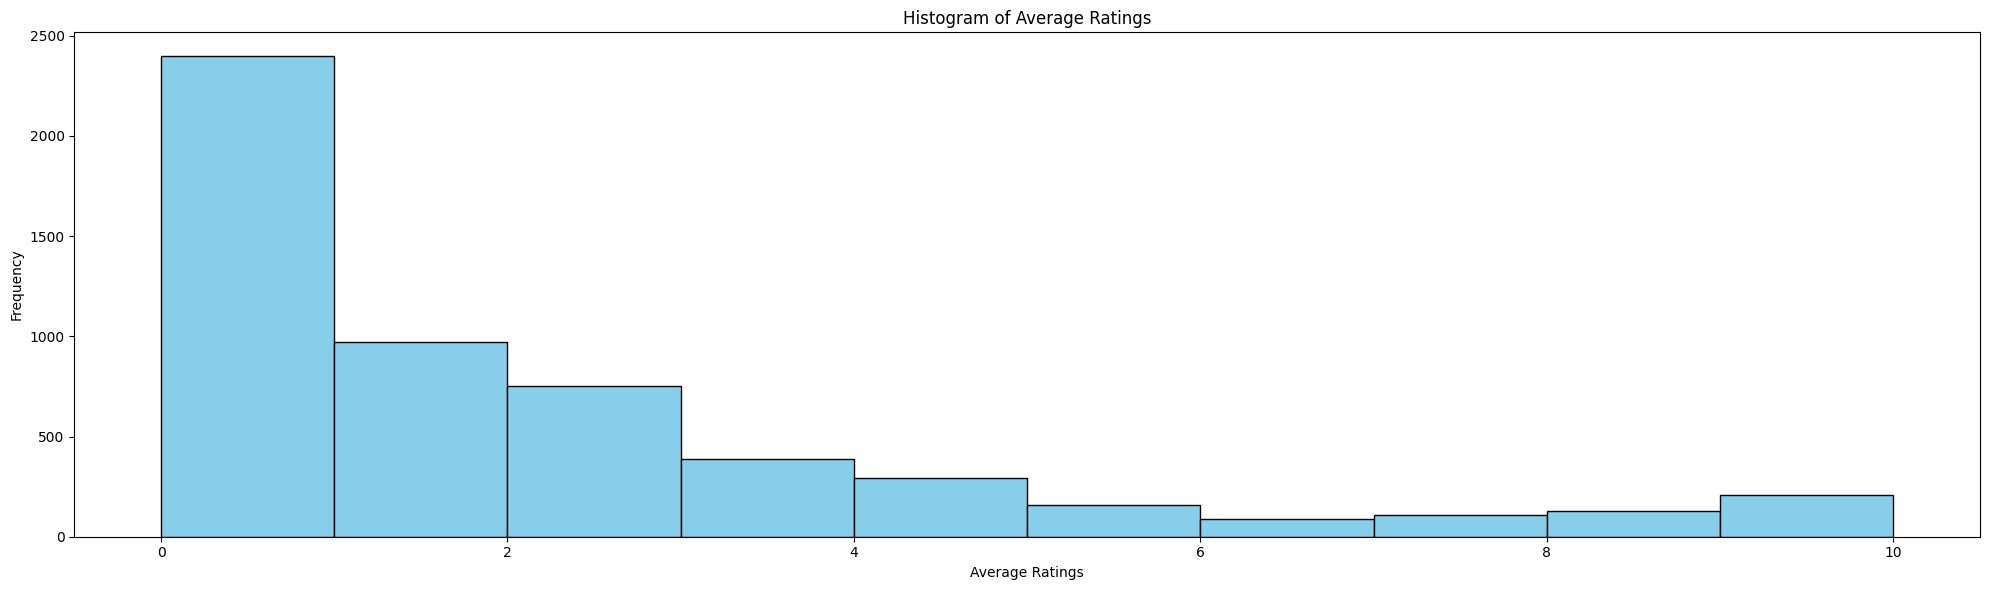

In [21]:
most_rated_books_average_ratings = -np.sort((-R.mean(0, where=P)))
plt.figure(figsize=(20, 6))
plt.hist(most_rated_books_average_ratings, bins=10, color='skyblue', edgecolor='black')
plt.xlabel('Average Ratings')
plt.ylabel('Frequency') # the number of book that share the same average rating score
plt.title('Histogram of Average Ratings')
plt.tight_layout()
plt.show()

Ram space cleanning up

In [22]:
#ratings_df = 0
#df = 0
del ratings_df
del df
gc.collect()

3708

# Data preparation

Creazione dataset

In [23]:
division_index=int(0.9*ratings.shape[0])
val_set = ratings.sparse.to_dense()

In [24]:

# Convertiamo il DataFrame sparsa in uno denso
dense_ratings = ratings.sparse.to_dense()

train_set = pd.DataFrame(index=dense_ratings.index, columns=dense_ratings.columns)
train_set[:] = np.nan

# Itera sulle righe
for index, row in dense_ratings.iterrows():
    non_nan_indices = row.dropna().index
    if len(non_nan_indices) == 1:
        train_set.at[index, non_nan_indices[0]] = dense_ratings.at[index, non_nan_indices[0]]
    else:
        num_samples = len(non_nan_indices)
        train_samples_idx = np.random.choice(num_samples, size=int(0.8 * num_samples), replace=False)
        selected_indices = [non_nan_indices[i] for i in train_samples_idx]
        for j in selected_indices:
            train_set.at[index, j] = dense_ratings.at[index, j]

# Converti nuovamente in sparsa
train_set = train_set.astype(pd.SparseDtype("float", np.nan))


In [25]:
del dense_ratings
gc.collect()

0

In [26]:
val_set.iloc[:3, :15]

isbn,0002005018,0002740230,0006276199,0006329527,000636988X,0006476333,000649840X,0006513409,0006550789,0006642004,0006643094,0007100221,0007103999,0007108648,0007119860
user_id,,,,,,,,,,,,,,,
11676,8.0,NaN,NaN,NaN,NaN,NaN,8.0,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN
3363,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35859,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
train_set.iloc[:3, :15]

isbn,0002005018,0002740230,0006276199,0006329527,000636988X,0006476333,000649840X,0006513409,0006550789,0006642004,0006643094,0007100221,0007103999,0007108648,0007119860
user_id,,,,,,,,,,,,,,,
11676,8.0,NaN,NaN,NaN,NaN,NaN,8.0,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN
3363,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35859,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
val_set.shape == train_set.shape

True

In [29]:
val_set = val_set.reindex_like(train_set)

In [30]:
np.array_equal(train_set.index, val_set.index)

True

In [31]:
np.array_equal(train_set.columns, val_set.columns)

True

In [32]:
R_train = train_set.fillna(0).values
P_train = train_set.notna().values

R_val = val_set.fillna(0).values
P_val = val_set.notna().values

In [33]:
val_actual = R_val[P_val]

# Prediction

## Collaborative prediction (Users)  Song lavora qui

Similarity calculation between an user `a` and an user `b` over item `i`:
$$ \text{sim}(u,v) = \frac{\sum_{i\in C_{u,v}} r_{u,i}\cdot r_{v,i}}{\sqrt{\sum_{i\in C_{u,v}} r_{u,i}^2}\cdot\sqrt{\sum_{i\in C_{u,v}} r_{v,i}^2}}$$

In [34]:
R = R_train
P = P_train
print(R.shape, P.shape) # = M X N
# Where M is the number of users and N is the number of items

(300, 6911) (300, 6911)


if i want to get the cos similarity bewteen users (m x n) @ (n x m) = (m x m) which is (user_dim x user_dim)

In [35]:
sim_numerator = R @ R.T
sim_numerator.shape

(300, 300)

In order to calculate the denominator, we need the norm of the scores between a pair of users, and we will only take the scores where the matrix P shows `True`

In [36]:
# a vector of dimension m x m x n, that is (user, user, boolean)
# we have m x n,  so we need to add 1 dimension to m
# that can be (1, m, n) and (m, 1, n)
P_rated = P[None, :, :] & P[:, None, :]
P_rated.shape

(300, 300, 6911)

Now we need a 3d vector of dimension (m x m x n), that is (user, user, score), this matrix contains information about ratings of items only if the item is rated by both users

In [37]:
#(m x m x n) * (1, m, n) = (m, m, n)
R_both_rated = P_rated * R
R_both_rated.shape
# although in this case, we have (m,m,n), but the score
#will be of the user in the second dimension(dim=1) in the 3d array (_, m, _)

(300, 300, 6911)

Now we can calculate the normalization of the denominator

In [38]:
R_both_rated_norm = np.linalg.norm(R_both_rated, axis=2)
#axis = 2 because that is the dimension where rating is saved
R_both_rated_norm.shape

(300, 300)

Then, we get the square of the values of the matrix
$${\sqrt{\sum_{i\in C_{u,v}} r_{u,i}^2}\cdot\sqrt{\sum_{i\in C_{u,v}} r_{v,i}^2}}$$

In [39]:
similarity_denominator = R_both_rated_norm * R_both_rated_norm.T
similarity_denominator.shape

(300, 300)

In [40]:
cosin_sim = sim_numerator / similarity_denominator
cosin_sim[:5, :5]

array([[1.        , 0.28758613, 0.32594049, 0.4046839 , 0.12117279],
       [0.28758613, 1.        , 0.15092674, 0.27765914, 0.        ],
       [0.32594049, 0.15092674, 1.        , 0.42133934, 0.30366369],
       [0.4046839 , 0.27765914, 0.42133934, 1.        , 0.26450662],
       [0.12117279, 0.        , 0.30366369, 0.26450662, 1.        ]])

We replace nan with the value zero

In [41]:
cosin_sim = np.where(np.isnan(cosin_sim), 0, cosin_sim)
cosin_sim[:50, :50]

array([[1.        , 0.28758613, 0.32594049, ..., 0.        , 0.33268082,
        0.25732214],
       [0.28758613, 1.        , 0.15092674, ..., 0.        , 0.        ,
        0.16877885],
       [0.32594049, 0.15092674, 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.33268082, 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.25732214, 0.16877885, 0.        , ..., 0.        , 0.        ,
        1.        ]])

When we have a sparse matrix, this would not work so well.

Now we can test this method on our validation dataset

In [42]:
def get_val_predictions(pred_func, k):
    return np.array([
        pred_func(u, i, k)
        for u, i in zip(*P_val.nonzero())
    ])

In [43]:
def RMSE(actual, predicted):
    return np.sqrt(np.mean(np.square(predicted - actual)))

In [44]:
def predict_from_neighbors(u, i, k):
    voters = list(P[:, i].nonzero()[0])
    voters.sort(key=lambda x: cosin_sim[u, x], reverse=True)
    voters = voters[:k]
    predicted_vote = (cosin_sim[u, voters] @ R[voters, i]) / cosin_sim[u, voters].sum()
    return predicted_vote if not np.isnan(predicted_vote) else R[P].mean()

In [45]:
K_similar_users = 5

In [46]:
k_sim_mserr = [RMSE(val_actual, get_val_predictions(predict_from_neighbors, k)) for k in range(K_similar_users)]

KeyboardInterrupt: ignored

In [ ]:
plt.title("Line graph of mse error in the function of k similar users")
plt.xlabel("k similarity")
plt.ylabel("rmse error")
plt.plot(np.arange(K_similar_users), k_sim_mserr, color ="red")
plt.show()

From this chart, we can see that there is no neccessary that we need to compute the similarity among all users, but just 3 is enough.

In [ ]:
print(P.shape[0])

In [47]:
val_predictions = get_val_predictions(predict_from_neighbors, P.shape[0])
RMSE(val_actual, val_predictions)

2.6263691380884366

In [48]:
val_predictions = get_val_predictions(predict_from_neighbors, 3)
RMSE(val_actual, val_predictions)

2.246514174971863

## Prediction models (Giuseppe lavora qui)

### Bayesian model


In [49]:
def bayesian_recommendation(matrix, user_vector):
    num_books = matrix.shape[1]

    best_ratings_for_user = []

    # 1. Identifica gli articoli/libri per cui l'utente di riferimento ha dato una valutazione
    rated_by_user = ~np.isnan(user_vector)

    # 2. Filtra gli utenti che hanno votato gli stessi libri dell'utente target
    similar_users_mask = ~np.isnan(matrix[:, rated_by_user]).all(axis=1)
    filtered_matrix = matrix[similar_users_mask]

    for i in range(num_books):
        # Se l'utente ha già valutato il libro, saltalo
        if not np.isnan(user_vector[i]):
            continue

        best_rating_for_book = None
        best_prob = -np.inf  # inizializziamo a un valore molto basso

        # Calcola la probabilità a priori per ogni rating per il libro corrente
        unique_ratings, counts = np.unique(filtered_matrix[:, i][~np.isnan(filtered_matrix[:, i])], return_counts=True)
        total_ratings = np.sum(counts)
        p_y = dict(zip(unique_ratings, counts / total_ratings))

        for rating in range(11):  # 0-10 ratings
            # Calcola una versione semplificata di P(X|Y=rating)
            p_x_given_y = np.nanmean(filtered_matrix[:, i] == rating)

            # Calcola P(Y=rating|X) come P(X|Y) * P(Y)
            p_y_given_x = p_x_given_y * p_y.get(rating, 0)

            if p_y_given_x > best_prob:
                best_prob = p_y_given_x
                best_rating_for_book = rating

        best_ratings_for_user.append((i, best_rating_for_book))

    return best_ratings_for_user


In [50]:

matrix = np.array([
    [1,3,3,2,np.nan],
    [2,4,2,2,4],
    [1,3,3,5,1],
    [4,5,2,3,3],
    [1,1,5,2,1]
])

user_vector = np.array([5,4,3,2,np.nan])

In [51]:
matrix = ratings.to_numpy()
user_vector=matrix[0]

In [52]:
print(bayesian_recommendation(matrix, user_vector))

[(1, 0), (2, 0), (3, 5), (4, 0), (5, 0), (7, 0), (9, 0), (10, 0), (11, 0), (12, 0), (13, 0), (14, 0), (16, 0), (17, 0), (18, 0), (19, 0), (20, 0), (21, 0), (22, 0), (23, 0), (24, 0), (26, 7), (28, 0), (29, 0), (30, 0), (31, 0), (32, 0), (33, 0), (35, 0), (36, 0), (37, 9), (38, 0), (39, 0), (40, 0), (41, 0), (42, 0), (43, 0), (44, 0), (45, 0), (46, 7), (47, 0), (48, 0), (49, 0), (50, 0), (51, 0), (52, 0), (53, 0), (54, 0), (55, 0), (56, 0), (57, 0), (60, 0), (61, 0), (63, 0), (64, 0), (65, 0), (66, 0), (69, 0), (70, 0), (71, 0), (73, 0), (74, 0), (75, 0), (76, 0), (78, 0), (79, 0), (80, 9), (81, 0), (82, 0), (83, 0), (84, 0), (85, 0), (86, 0), (89, 0), (90, 0), (91, 0), (92, 0), (93, 0), (94, 0), (95, 0), (96, 0), (98, 8), (99, 0), (100, 0), (101, 0), (104, 0), (105, 0), (108, 8), (109, 0), (110, 0), (111, 0), (112, 0), (114, 0), (115, 0), (116, 0), (117, 8), (119, 10), (120, 0), (123, 0), (124, 0), (126, 0), (127, 0), (128, 0), (129, 0), (130, 7), (131, 0), (132, 0), (134, 0), (135, 0)

KNN clustering

In [53]:
k = 10

In [54]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 9.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=2811595 sha256=32df286f223777c0f9d821354f3e7225de498a06bf2f55f2f9e1fdd15a3fef39
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [55]:
train_set_stacked = train_set.stack()
train_set_stacked = train_set_stacked.reset_index()

In [94]:
from surprise import Dataset
from surprise import Reader
from surprise.dataset import DatasetAutoFolds

reader = Reader(rating_scale=(1, 5))
train_dataset = Dataset.load_from_df(train_set_stacked, reader)


In [95]:
train_dataset = pd.DataFrame(train_dataset.__dict__['raw_ratings'], columns=['user_id','item_id','rating','timestamp'])

In [98]:
train_dataset[train_dataset["rating"] == 0] = 1e-5

In [99]:
train_dataset = train_dataset.drop(columns=["timestamp"])

In [100]:
train_dataset = Dataset.load_from_df(train_dataset, reader)

In [101]:
trainset = train_dataset.build_full_trainset()

In [102]:
from surprise import KNNBasic
model = KNNBasic(k=trainset.n_users, sim_options={"name": "cosine"})

In [103]:
model.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [ ]:
user0 = ratings.index[0]
item0 = ratings.columns[0]
pred = model.predict(user0, item0)